## Object Detection on Malaysian Food

This notebook aims to develop a (hopefully small and robot compatible) object detection model to detect and classify Malaysian food of five different classes:
- Roti Canai
- Nasi Lemak
- Nasi Goreng
- Satay
- Mee Goreng

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 25.5 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import random
from xml.etree import ElementTree
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

In [ ]:
# Initial renaming script (no longer necessary)

# folders = ["mee_goreng", "nasi_goreng", "nasi_lemak", "roti_canai", "satay"]

# for folder in folders:
#   folder_path = os.path.join(data_dir, folder)
#   image_list = os.listdir(folder_path)

#   for image in image_list:
#     new_file_name = f"{folder}_{image}"
#     os.rename(os.path.join(folder_path, image), os.path.join(folder_path, new_file_name))

### Reformating the annotations into a simpler DataFrame

The annotations in the form of the bounding box and labels exported in the CVAT format are reformatted and merged into a DataFrame.

In [ ]:
project_drive = os.path.join("/content/drive", "MyDrive/Group Project robotic")
data_dir = os.path.join(project_drive, "data_gambar")

def format_annotations(folder, annotation_file_path):
  ''' Utility function to parse XML files and create a DataFrame of annotations.

  Args:
    folder (str): Name of the folder that stores the image, eg. "mee_goreng"
    file_path (str): The absolute file path of the annotation file to parse.

  Returns:
    df (pd.DataFrame): A DataFrame of annotations containing 5 columns: file_name, label, xmin, ymin, xmax, ymax.
  '''

  tree = ElementTree.parse(annotation_file_path)
  root = tree.getroot()
  images = root.findall("image")

  annotations = []

  for image in images:
    file_name = image.attrib["name"]
    bboxes = image.findall("box")

    if len(bboxes) > 0:

      for bbox in bboxes:
        bbox_dict = {}

        attributes = bbox.attrib
        label, xtl, ytl, xbr, ybr = attributes["label"], attributes["xtl"], attributes["ytl"], attributes["xbr"], attributes["ybr"]

        # The file name is reconstructed as they were renamed after some of the annotation tasks were completed.
        # This may need to be adjusted for future work.
        bbox_dict["file_name"] = f"{folder}_{file_name}"
        bbox_dict["label"] = label
        bbox_dict["xmin"] = xtl
        bbox_dict["ymin"] = ytl
        bbox_dict["xmax"] = xbr
        bbox_dict["ymax"] = ybr

        annotations.append(bbox_dict)

  df = pd.DataFrame(annotations)
  return df

In [ ]:
annotation_files = [file_name for file_name in os.listdir(data_dir) if "xml" in file_name]

df = pd.DataFrame(columns=["file_name", "label", "xmin", "ymin", "xmax", "ymax"])

for file_name in annotation_files:
  file_path = os.path.join(data_dir, file_name)
  underscore_loc = file_name.find("_")
  period_loc = file_name.find(".")

  folder_name = file_name[underscore_loc+1 : period_loc]

  file_df = format_annotations(folder_name, file_path)
  df = pd.concat([df, file_df], ignore_index=True)

df

,file_name,label,xmin,ymin,xmax,ymax
0,nasi_goreng_1.jpg,nasi_goreng,27.19,33.90,490.61,499.24
1,nasi_goreng_10.jpg,nasi_goreng,20.61,52.81,497.07,292.84
2,nasi_goreng_102.jpg,nasi_goreng,12.37,40.45,487.29,333.02
3,nasi_goreng_109.jpg,nasi_goreng,13.87,24.84,485.23,377.68
4,nasi_goreng_110.jpg,nasi_goreng,6.03,67.14,507.23,488.37
...,...,...,...,...,...,...
899,roti_canai_94.jpg,roti_canai,0.00,261.81,878.28,960.00
900,roti_canai_95.jpg,roti_canai,0.00,71.63,1080.00,1080.00
901,roti_canai_97.jpg,roti_canai,0.00,79.18,599.00,749.00
902,roti_canai_98.jpg,roti_canai,0.00,0.00,1080.00,1080.00


In [ ]:
# Uncomment to save in the Drive folder.
# df.to_csv(f"{data_dir}/food_dataset_annotations.csv", index=False)

In [ ]:
# Reading the newly created annotations file back as a DataFrame
df = pd.read_csv(f"{data_dir}/food_dataset_annotations.csv")
df

,file_name,label,xmin,ymin,xmax,ymax
0,nasi_goreng_1.jpg,nasi_goreng,27.19,33.90,490.61,499.24
1,nasi_goreng_10.jpg,nasi_goreng,20.61,52.81,497.07,292.84
2,nasi_goreng_102.jpg,nasi_goreng,12.37,40.45,487.29,333.02
3,nasi_goreng_109.jpg,nasi_goreng,13.87,24.84,485.23,377.68
4,nasi_goreng_110.jpg,nasi_goreng,6.03,67.14,507.23,488.37
...,...,...,...,...,...,...
899,roti_canai_94.jpg,roti_canai,0.00,261.81,878.28,960.00
900,roti_canai_95.jpg,roti_canai,0.00,71.63,1080.00,1080.00
901,roti_canai_97.jpg,roti_canai,0.00,79.18,599.00,749.00
902,roti_canai_98.jpg,roti_canai,0.00,0.00,1080.00,1080.00


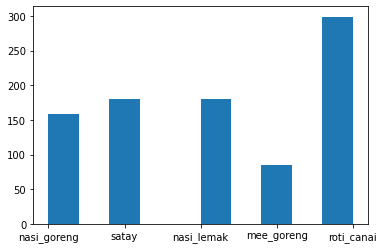

In [ ]:
df["label"].hist()
plt.grid(False)
plt.show()

In [ ]:
np.random.seed(7)

label_list = df["label"].values

train_indices, test_indices, _, _ = train_test_split(
    range(df.shape[0]),
    label_list,
    stratify=label_list,
    train_size=0.8,
)

print("Length of Training Split:", len(train_indices))
print("Length of Test Split:", len(test_indices))

Length of Training Split: 723
Length of Test Split: 181


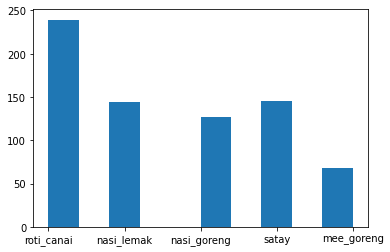

In [ ]:
df.iloc[train_indices]["label"].hist()
plt.grid(False)
plt.show()

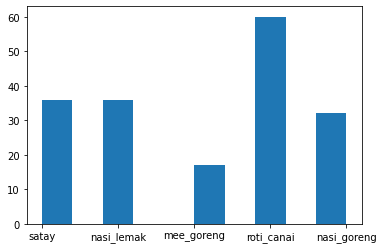

In [ ]:
df.iloc[test_indices]["label"].hist()
plt.grid(False)
plt.show()

### Food Dataset

This is a custom PyTorch dataset that can load the images from the specific directories, apply transformations and return the appropriate target dictionary based on the annotations file.

In [ ]:
class FoodDataset(Dataset):

    def __init__(self, root, images, annotations_df, classes, transforms=None):
        self.root = root
        self.images = images
        self.annotations = annotations_df
        self.classes = classes
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        # split_image_name = image_name.split("_")
        # folder_name = self.annotations.iloc[idx]["label"]
        # folder_name = f"{split_image_name[0]}_{split_image_name[1]}"

        suffix_loc = re.search("_[0-9]+", image_name).span()
        folder_name = image_name[:suffix_loc[0]]

        img = Image.open(os.path.join(self.root, folder_name, image_name)).convert("RGB")
        boxes = []
        labels = []

        image_annotations = self.annotations[self.annotations["file_name"] == image_name]

        for index, rows in image_annotations.iterrows():
            boxes.append([rows["xmin"], rows["ymin"], rows["xmax"], rows["ymax"]])
            labels.append(self.classes.index(rows["label"]))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

In [ ]:
torch.manual_seed(7)

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

train_transforms = transforms.Compose([transforms.ToTensor()])

image_names = df["file_name"].values
classes = ["mee_goreng", "nasi_goreng", "nasi_lemak", "roti_canai", "satay"]

train_dataset = FoodDataset(data_dir, image_names[train_indices], df, classes, transforms=train_transforms)
test_dataset = FoodDataset(data_dir, image_names[test_indices], df, classes, transforms=train_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

print(len(train_dataset))
print(len(test_dataset))

723
181


### Sanity check on the dataset and their annotations

This cell displays a sample image and the bounding boxes and ground truth labels present in the image.

Image Index 531 | Actual Labels: nasi_goreng


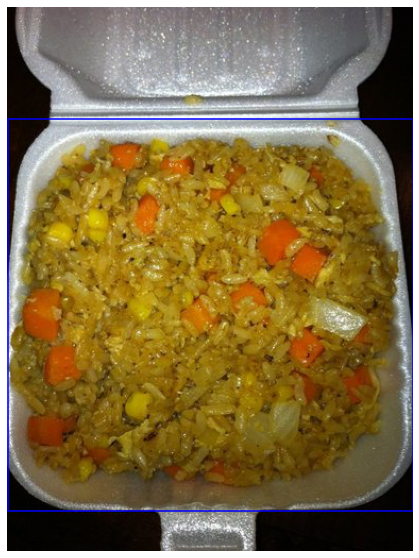

In [ ]:
def display_annotated_image(image, target):

  num_sample_labels = len(target["boxes"])

  plt.figure(figsize=(15,10))
  plt.axis("off")
  plt.imshow(sample_image.permute(1, 2, 0))
  ax = plt.gca()

  for i in range(num_sample_labels):
      xmin, ymin, xmax, ymax = target["boxes"][i]
      starting_coor = (xmin, ymin)
      height = ymax - ymin
      width = xmax - xmin
      
      rect = Rectangle(starting_coor, width, height, linewidth=1.5, edgecolor='b', facecolor='none')

      # Add the patch to the Axes
      ax.add_patch(rect)

  # This handles both the cases of having a single label and multiple labels in the image
  ground_truths = ", ".join(classes[idx] for idx in target["labels"])
  print(f"Image Index {image_id} | Actual Labels: {ground_truths}")
  plt.show()

image_id = random.randint(0, len(train_dataset))
# image_id = 178
sample_image = train_dataset[image_id][0]
target = train_dataset[image_id][1]

display_annotated_image(sample_image, target)

### Model Definition

The current model used is a Faster RCNN model with the mobilenet backend. The original head is replaced with a custom head where the number of classes is 5, equivalent to the number of food classes present in our dataset.

In [ ]:
torch.manual_seed(7)

# Load a pretrained model trained on the COCO dataset.
# https://pytorch.org/vision/stable/generated/torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn.html
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

num_classes = len(classes)
# Get the number of input features for the classifier and create a new head with our number of classes.
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params)

model = model.cuda()
model

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequen

### Model Training

In [ ]:
torch.manual_seed(7)

def train(model, optimizer, data_loader, epoch):
    """ Function that trains the model for one epoch.

    Args:
      model: The model to be trained.
      optimizer: The optimizer to compute and update the gradients.
      data_loader: The dataloader used for training.
      epoch (int): The current epoch the model is being trained in.

    Returns:
      average_mini_batch_loss: The average mini batch loss for the epoch. 
    """
    
    model.train()

    # mini_batch_losses = []
    loss = 0

    with tqdm(data_loader, unit="batch") as train_batch:
        train_batch.set_description(f"Epoch: {epoch} --------------------")

        for batch in train_batch:
            images, targets = batch

            images = list(image.cuda() for image in images)
            targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            # Note that object detection models have multiple losses.
            # Hence, the following sums up the losses in order to have a view of the total loss accross all the criterias.
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss += loss_value

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
    
    average_mini_batch_loss = loss / len(data_loader)

    return average_mini_batch_loss

epochs = 10
training_losses = []
for epoch in range(1, epochs+1):
    average_mb_loss = train(model, optimizer, train_dataloader, epoch)

    print(f"Average Training Mini Batch Loss: {average_mb_loss}")
    training_losses.append(average_mb_loss)

Epoch: 1 --------------------: 100%|██████████| 46/46 [03:58<00:00,  5.19s/batch]


Average Training Mini Batch Loss: 1.5182214379310608


Epoch: 2 --------------------: 100%|██████████| 46/46 [00:30<00:00,  1.49batch/s]


Average Training Mini Batch Loss: 1.2793530160966127


Epoch: 3 --------------------: 100%|██████████| 46/46 [00:31<00:00,  1.48batch/s]


Average Training Mini Batch Loss: 1.2328090628852015


Epoch: 4 --------------------: 100%|██████████| 46/46 [00:31<00:00,  1.45batch/s]


Average Training Mini Batch Loss: 1.0664249477179155


Epoch: 5 --------------------: 100%|██████████| 46/46 [00:30<00:00,  1.49batch/s]


Average Training Mini Batch Loss: 0.8363492035347483


Epoch: 6 --------------------: 100%|██████████| 46/46 [00:30<00:00,  1.50batch/s]


Average Training Mini Batch Loss: 0.7465415292459986


Epoch: 7 --------------------: 100%|██████████| 46/46 [00:30<00:00,  1.49batch/s]


Average Training Mini Batch Loss: 0.9499980548153752


Epoch: 8 --------------------: 100%|██████████| 46/46 [00:30<00:00,  1.50batch/s]


Average Training Mini Batch Loss: 0.8056345102579697


Epoch: 9 --------------------: 100%|██████████| 46/46 [00:30<00:00,  1.50batch/s]


Average Training Mini Batch Loss: 0.7624844014644623


Epoch: 10 --------------------: 100%|██████████| 46/46 [00:30<00:00,  1.50batch/s]

Average Training Mini Batch Loss: 0.8080997531828673


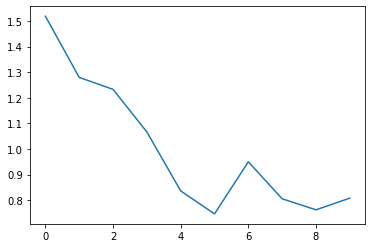

In [ ]:
plt.plot(training_losses)
plt.show()

satay 0.9688606858253479


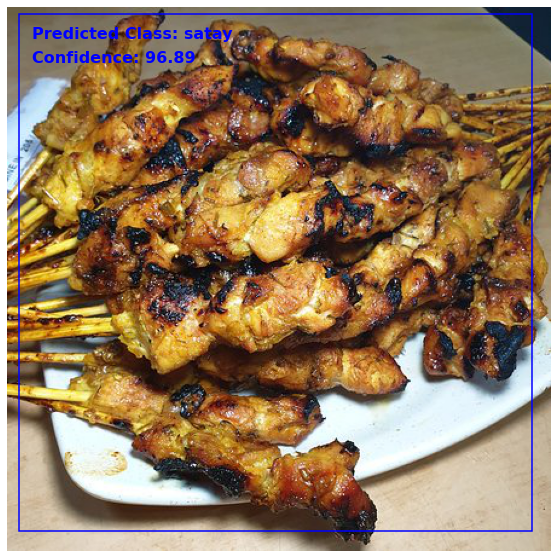

In [ ]:
model.eval()
img, ground_truth = test_dataset[5]

with torch.no_grad():
  gpu_img = img.cuda()
  prediction = model([gpu_img])[0]

boxes, labels, scores = prediction["boxes"], prediction["labels"], prediction["scores"]

for box, label, score in zip(boxes, labels, scores):
  if score > 0.5:
    print(classes[label], score.item())
    plt.figure(figsize=(15,10))
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
    ax = plt.gca()

    xmin, ymin, xmax, ymax = box.cpu().numpy()
    starting_coor = (xmin, ymin)
    height = ymax - ymin
    width = xmax - xmin
      
    rect = Rectangle(starting_coor, width, height, linewidth=1.5, edgecolor='b', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    label_coor = (starting_coor[0] + 10, starting_coor[1] + 20)
    score_coor = (starting_coor[0] + 10, starting_coor[1] + 40)

    label_annotation = f"Predicted Class: {classes[label]}"
    score_annotation = f"Confidence: {round(score.item() * 100, 2)}"

    ax.annotate(label_annotation, label_coor, color='b', weight='bold', size=16)
    ax.annotate(score_annotation, score_coor, color='b', weight='bold', size=16)
  
  plt.show()

### Model Evaluation using Mean Average Precision

In [ ]:
metrics = MeanAveragePrecision()
metrics.cuda()

for images, targets in test_dataloader:
  images = list(image.cuda() for image in images)
  targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

  predictions = model(images)
  metrics.update(predictions, targets)

In [ ]:
metrics.compute()

{'map': tensor(0.5497),
 'map_50': tensor(0.7812),
 'map_75': tensor(0.6222),
 'map_large': tensor(0.5497),
 'map_medium': tensor(-1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.5378),
 'mar_10': tensor(0.6037),
 'mar_100': tensor(0.6037),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.6037),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(-1.)}

In [ ]:
torch.save(model, "model_080622.pth")